In [1]:
using Rocket
using Distributions
using ReactiveMP
using BenchmarkTools

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function createSubgraph(model, index::Int)
    noise_add = add!(model, make_node(+))
    
    noise = add!(model, constvar(:noise, Normal(0.0, sqrt(200.0))))
    yn    = add!(model, datavar(:yn, Dirac{Float64}))
    
    connect!(noise_add, :in2, noise)
    connect!(noise_add, :out, yn)
    
    return (yn, noise_add)
end

function createGraph(size::Int)    
    model = Model(DefaultMessageGate())
    
    c0_add = add!(model, make_node(+))
    
    c0       = add!(model, constvar(:c0, 1.0))
    x0_prior = add!(model, datavar(:x0_prior, Normal{Float64}))
    
    connect!(c0_add, :in1, x0_prior)
    connect!(c0_add, :in2, c0)
    
    index = 1
    
    prev_c_add = c0_add
    
    xs = Vector{RandomVariable}(undef, size)
    ys = Vector{DataVariable}(undef, size)
    
    while index < size
        yn, noise_add = createSubgraph(model, index)
        xn            = add!(model, randomvar(:xn))
        
        c_add = add!(model, make_node(+))
        cn    = add!(model, constvar(:cn, 1.0))
        
        connect!(prev_c_add, :out, xn)
        connect!(noise_add, :in1, xn)
        connect!(c_add, :in1, xn)
        connect!(c_add, :in2, cn)
        
        activate!(model, prev_c_add)
        activate!(model, noise_add)
        
        xs[index] = xn
        ys[index] = yn
        
        prev_c_add = c_add
        
        index += 1
    end
    
    last_noise_add = add!(model, make_node(+));
    
    x_last     = add!(model, randomvar(:x_last))
    y_last     = add!(model, datavar(:ylast, Dirac{Float64}))
    last_noise = add!(model, constvar(:last_noise, Normal(0.0, sqrt(200.0))))
    
    connect!(prev_c_add, :out, x_last)
    connect!(last_noise_add, :in1, x_last)
    connect!(last_noise_add, :in2, last_noise)
    connect!(last_noise_add, :out, y_last)
    
    activate!(model)
    
    xs[size] = x_last
    ys[size] = y_last
    
    return (xs, ys, x0_prior)
end

createGraph (generic function with 1 method)

In [3]:
function smoothing(data)
    N = length(data)
    
    xs, ys, x_prior = createGraph(N);
    
    marginals     = Vector{Normal{Float64}}(undef, N)
    subscriptions = Vector{Teardown}(undef, N)
    
    for (index, x) in enumerate(xs)
        @inbounds subscriptions[index] = subscribe!(getmarginal(x), (d) -> marginals[index] = getdata(d))
    end
    
    update!(x_prior, Normal(0.0, sqrt(10000.0)))
    for i in 1:N
       @inbounds update!(ys[i], data[i])
    end
    
    foreach(unsubscribe!, subscriptions)
    
    return marginals
end

smoothing (generic function with 1 method)

In [4]:
N = 600
data = collect(1:N) + sqrt(200.0) * randn(N);

In [5]:
@time smoothing(data); # Initial compilation

  4.041418 seconds (10.66 M allocations: 575.084 MiB, 4.01% gc time)


In [6]:
@time smoothing(data); # Subsequent runs

  0.062683 seconds (578.01 k allocations: 35.508 MiB, 30.63% gc time)


In [7]:
@btime smoothing($data); # Performance benchmark

  42.180 ms (578015 allocations: 35.51 MiB)


In [8]:
using Plots

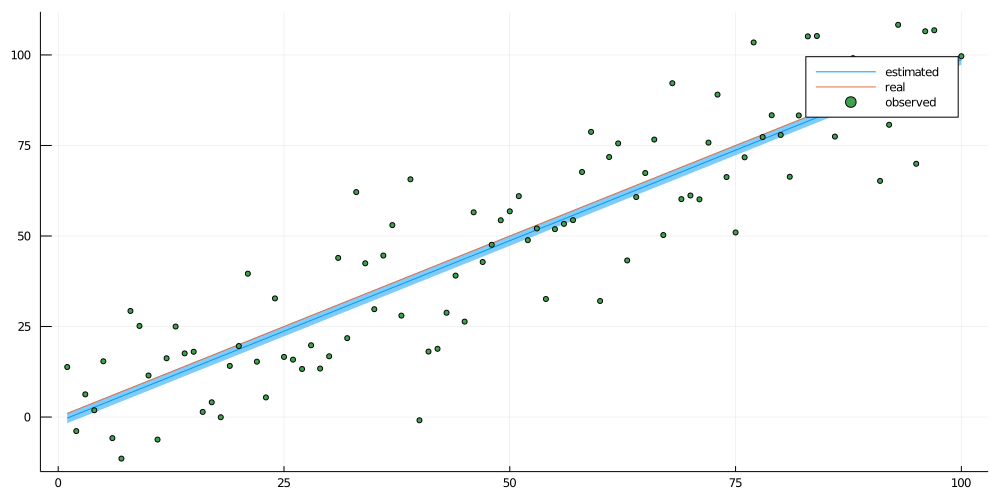

In [9]:
real_data = collect(1:100)
obs_data  = real_data .+ (sqrt(200.0) * randn(100));
estimated = smoothing(obs_data)

graph = plot(mean.(estimated), ribbon = std.(estimated), label = :estimated)
graph = plot!(graph, real_data, label = :real)
graph = scatter!(graph, obs_data, ms = 3, label = :observed)

plot(graph, size = (1000, 500))